# **Data 100 Final Project: An Exploratory Data Analysis of the Role of Public Policy During the COVID-19 Pandemic**

**Noor Gill and Natalia Ramirez**

First, we import all necessary libraries and tools: 

In [1]:
import io
import numpy as np
import pandas as pd
import pandas.util.testing as tm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import seaborn as sns; sns.set()
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as mse
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  after removing the cwd from sys.path.


Since we decided to work on the COVID-19 dataset, we uploaded the data files into Google Colab and read in the data sets as DataFrames so we could perform data cleaning, make observations, and conduct EDA. To understand what each attribute represents, we referred to the column descriptions in the README.md file. 

In [0]:
counties = pd.read_csv('https://raw.githubusercontent.com/Yu-Group/covid19-severity-prediction/master/data/county_data_abridged.csv')
states = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/04-18-2020.csv')
confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')

In [3]:
counties.head(5)

,countyFIPS,STATEFP,COUNTYFP,CountyName,StateName,State,lat,lon,POP_LATITUDE,POP_LONGITUDE,CensusRegionName,CensusDivisionName,Rural-UrbanContinuumCode2013,PopulationEstimate2018,PopTotalMale2017,PopTotalFemale2017,FracMale2017,PopulationEstimate65+2017,PopulationDensityperSqMile2010,CensusPopulation2010,MedianAge2010,#EligibleforMedicare2018,"MedicareEnrollment,AgedTot2017",3-YrDiabetes2015-17,DiabetesPercentage,HeartDiseaseMortality,StrokeMortality,Smokers_Percentage,RespMortalityRate2014,#FTEHospitalTotal2017,"TotalM.D.'s,TotNon-FedandFed2017",#HospParticipatinginNetwork2017,#Hospitals,#ICU_beds,dem_to_rep_ratio,PopMale<52010,PopFmle<52010,PopMale5-92010,PopFmle5-92010,PopMale10-142010,...,PopMale30-342010,PopFmle30-342010,PopMale35-442010,PopFmle35-442010,PopMale45-542010,PopFmle45-542010,PopMale55-592010,PopFmle55-592010,PopMale60-642010,PopFmle60-642010,PopMale65-742010,PopFmle65-742010,PopMale75-842010,PopFmle75-842010,PopMale>842010,PopFmle>842010,3-YrMortalityAge<1Year2015-17,3-YrMortalityAge1-4Years2015-17,3-YrMortalityAge5-14Years2015-17,3-YrMortalityAge15-24Years2015-17,3-YrMortalityAge25-34Years2015-17,3-YrMortalityAge35-44Years2015-17,3-YrMortalityAge45-54Years2015-17,3-YrMortalityAge55-64Years2015-17,3-YrMortalityAge65-74Years2015-17,3-YrMortalityAge75-84Years2015-17,3-YrMortalityAge85+Years2015-17,mortality2015-17Estimated,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,SVIPercentile,HPSAShortage,HPSAServedPop,HPSAUnderservedPop
0,01001,1.0,1.0,Autauga,AL,Alabama,32.540091,-86.645649,32.500389,-86.494165,South,East South Central,2.0,55601.0,27007.0,28497.0,0.486578,8392.0,91.8,54571.0,37.0,11439.0,8046.0,16.0,9.9,204.5,56.1,18.081557,81.79,324.0,50.0,0.0,1.0,6.0,0.326656,1866.0,1713.0,2001.0,1990.0,2171.0,...,1594.0,1736.0,3978.0,4265.0,4040.0,4165.0,1524.0,1559.0,1279.0,1498.0,1821.0,2192.0,841.0,1141.0,159.0,392.0,NaN,NaN,NaN,NaN,10.0,20.0,44.0,73.0,112.0,143.0,109.0,NaN,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.4354,NaN,NaN,NaN
1,01003,1.0,3.0,Baldwin,AL,Alabama,30.738314,-87.726272,30.548923,-87.762381,South,East South Central,3.0,218022.0,103225.0,109403.0,0.485472,42413.0,114.7,182265.0,41.1,54145.0,41590.0,33.0,8.5,183.2,41.9,17.489033,54.28,2101.0,536.0,0.0,3.0,51.0,0.253255,5614.0,5544.0,5832.0,5767.0,6076.0,...,5317.0,5392.0,11620.0,11933.0,13047.0,13874.0,5943.0,6580.0,5728.0,6284.0,8558.0,9245.0,4379.0,5153.0,1176.0,2057.0,13.0,NaN,NaN,23.0,30.0,52.0,125.0,262.0,434.0,546.0,597.0,NaN,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.2162,NaN,NaN,NaN
2,01005,1.0,5.0,Barbour,AL,Alabama,31.874030,-85.397327,31.844036,-85.310038,South,East South Central,6.0,24881.0,13335.0,11935.0,0.527701,4757.0,31.0,27457.0,39.0,6681.0,4706.0,NaN,15.7,220.4,49.0,21.999985,69.82,181.0,12.0,0.0,1.0,5.0,0.893106,847.0,855.0,826.0,816.0,820.0,...,1162.0,646.0,2115.0,1513.0,2164.0,1854.0,910.0,907.0,859.0,940.0,1067.0,1171.0,498.0,730.0,129.0,314.0,NaN,NaN,NaN,NaN,NaN,NaN,21.0,44.0,65.0,72.0,68.0,NaN,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.9959,6.08,5400.0,18241.0
3,01007,1.0,7.0,Bibb,AL,Alabama,32.999024,-87.125260,33.030921,-87.127659,South,East South Central,1.0,22400.0,12138.0,10530.0,0.535469,3632.0,36.8,22915.0,37.8,5128.0,3389.0,NaN,13.3,225.5,57.2,19.114200,84.49,145.0,16.0,0.0,1.0,0.0,0.278124,712.0,666.0,759.0,646.0,771.0,...,1013.0,633.0,1895.0,1487.0,1883.0,1503.0,734.0,667.0,684.0,650.0,803.0,920.0,370.0,534.0,73.0,206.0,NaN,NaN,NaN,NaN,NaN,NaN,24.0,37.0,62.0,56.0,45.0,NaN,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.6003,2.75,14980.0,6120.0
4,01009,1.0,9.0,Blount,AL,Alabama,33.990440,-86.562711,33.955243,-86.591491,South,East South Central,1.0,57840.0,28607.0,29406.0,0.493114,10351.0,88.9,57322.0,39.0,13175.0,9542.0,NaN,14.9,224.8,52.8,19.208672,87.05,103.0,18.0,1.0,1.0,6.0,0.094317,1805.0,1811.0,1936.0,1944

In [4]:
states.head(5)

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,2020-04-18 22:32:47,32.3182,-86.9023,4712,153,NaN,4559.0,1.0,100.492717,42538.0,620.0,3.247029,84000001,USA,907.206961,13.157895
1,Alaska,US,2020-04-18 22:32:47,61.3707,-152.4044,314,9,147.0,305.0,2.0,52.530410,9655.0,39.0,2.866242,84000002,USA,1615.226458,12.420382
2,American Samoa,US,NaN,-14.2710,-170.1320,0,0,NaN,NaN,60.0,0.000000,3.0,NaN,NaN,16,ASM,5.391708,NaN
3,Arizona,US,2020-04-18 22:32:47,33.7298,-111.4312,4724,180,539.0,4544.0,4.0,64.901548,51045.0,566.0,3.810330,84000004,USA,701.291175,11.981372
4,Arkansas,US,2020-04-18 22:32:47,34.9697,-92.3731,1744,38,703.0,1706.0,5.0,67.361213,24141.0,291.0,2.178899,84000005,USA,932.435235,16.685780


In [5]:
confirmed.head(5)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,"American Samoa, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,"Guam, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,113,121,121,128,130,133,133,133,133,135,135,136,136,136,136,136,136,139,141,141,141,141,141,141,145,145,145,145,145,145,149,149,151,151,151,151,152,152,152,154
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,"Northern Mariana Islands, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,8,8,11,11,11,11,11,11,11,13,13,13,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,15,15,15,16,16,19,19,19,19,19
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.2208,-66.5901,"Puerto Rico, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,513,573,620,683,725,788,897,903,923,974,1043,1068,1118,1213,1252,1298,1252,1416,1276,1307,1371,1389,1400,1433,1539,1575,1757,1808,1843,1924,1968,2031,2156,2173,2198,2256,2299,2329,2427,2542
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.3358,-64.8963,"Virgin Islands, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,43,43,45,45,50,51,51,51,51,51,51,51,53,53,53,53,54,54,54,55,57,57,57,57,66,66,66,66,66,66,66,66,68,68,69,69,69,69,69,69


In [6]:
deaths.head(5)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Population,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,...,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,"American Samoa, US",55641,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,"Guam, US",164229,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,4,4,4,4,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,"Northern Mariana Islands, US",55144,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.2208,-66.5901,"Puerto Rico, US",2933408,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,21,23,24,33,39,42,44,45,45,51,56,58,60,62,63,64,63,69,77,83,84,84,86,86,92,94,95,97,97,99,99,102,107,108,111,113,114,115,117,122
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.3358,-64.8963,"Virgin Islands, US",107268,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1,1,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,5,6,6,6,6


### **Data Cleaning Process**

1. **Structure** - For each of the relations, the index is set at unique numerical indices for each row. However, attributes such as "UID" or "FIPS," as seen in the states and confirmed DataFrames, could also potentially be used as primary keys. It appears that there is quantitative continuous data in columns such as "Incident_Rate," "Lat," and "Long_" as well as quantitative discrete data in columns such as "Population," "Confirmed," and "Recovered." There is also qualitative nominal data in columns such as "Country_Region" and "Province_State." 

2. **Granularity** - In the counties DataFrame, each record represents a county. In the states DataFrame, each record represents a state. In the confirmed and deaths DataFrames, each record represents a geographic region characterized as either a county in the United States or United States territory such as Puerto Rico and Guam. In all 4 DataFrames, quantitative values are aggregated by count.

3. **Scope** - The data covers the area of interest, which is the United States in this case. The data is also expansive as it incorporates United States territorial regions. The data covers roughly the correct time frame since this is a fairly recent dataset from January to April 2020; we expect the data to reflect information up until the present day since it is continuously being updated for May 2020. The sampling frame is the United States of America for this dataset. 




4. **Temporality** - The states DataFrame includes a "Last_Update" attribute, which represents the time that the data was inputted and/or updated. This is compliant with Unix/POSIX Time formatting. The confirmed and deaths DataFrames include attributes corresponding to specific dates, with times that are not unique based on index. 

5. **Faithfulness** - Upon observing the updated states data available online, it is evident that some NaN recovered data from 4/18 is filled in with 0 values in the updated sets, so we assume this to be the most reliable data provided. In one-hot encoding, we replace NaN values with 0, which allows us to disregard the impact of that cell in the case of calculating np.mean or np.sum. For the confirmed and death DataFrames, substituting 0 for NaN values allows us to make the assumption that no confirmed case or death was reported in that particular instance, which is reasonable considering the adaptive nature of current COVID-19 data collection.


In [0]:
confirmed = confirmed.fillna(0)
deaths = deaths.fillna(0)

While these are the observations we have made so far, through subsequent analysis we identify and resolve any violations of obvious dependencies, signs of data falsification, missing/truncated data...etc.

## **Question 1: Can we use prior information of precautionary measures and policies enacted in response to COVID-19 in various counties to predict the spread of the virus?**

We isolated the attributes associated with precautionary measures and shelter-in-place policies based on the counties DataFrame provided. We named this relation, policies.

In [8]:
policies = counties.reset_index()[['CountyName', 'PopulationEstimate2018', 'State','stay at home', '>50 gatherings', '>500 gatherings', 'public schools', 'restaurant dine-in', 
                      'entertainment/gym', 'federal guidelines', 'foreign travel ban']]
policies.head(10)

,CountyName,PopulationEstimate2018,State,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban
0,Autauga,55601.0,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0
1,Baldwin,218022.0,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0
2,Barbour,24881.0,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0
3,Bibb,22400.0,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0
4,Blount,57840.0,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0
5,Bullock,10138.0,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0
6,Butler,19680.0,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0
7,Calhoun,114277.0,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0
8,Chambers,33615.0,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0
9,Cherokee,26032.0,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0


We noticed there were counties with null values as names so we decided to remove these counties as there was no form of identification for them and the indicident could potentially represent data falsification. Moreover, for counties such as New York City and Kansas City, the values for all policy attributes were NaN, hence we also removed these indices from the DataFrame since further analysis would not be effective due to this missing data. 

In [9]:
policies = policies[~policies['CountyName'].isin(['NaN'])]
policies = policies[~policies['PopulationEstimate2018'].isin(['NaN'])]
policies.head(5)

,CountyName,PopulationEstimate2018,State,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban
0,Autauga,55601.0,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0
1,Baldwin,218022.0,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0
2,Barbour,24881.0,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0
3,Bibb,22400.0,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0
4,Blount,57840.0,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0


We isolated the data of the number of confirmed cases reported on a daily basis based on the confirmed dataframe by removing extraneous attributes such as "Lat" and "Long_." We named this relation, confirmed_cases.


In [10]:
confirmed_cases = confirmed.drop(axis = 1, columns = ['UID', 'iso2', 'iso3', 'code3', 'Country_Region', 'Lat', 'Long_', 'Combined_Key'])
confirmed_cases.head(10)

,FIPS,Admin2,Province_State,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,...,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20
0,60.0,0,American Samoa,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,66.0,0,Guam,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,113,121,121,128,130,133,133,133,133,135,135,136,136,136,136,136,136,139,141,141,141,141,141,141,145,145,145,145,145,145,149,149,151,151,151,151,152,152,152,154
2,69.0,0,Northern Mariana Islands,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,8,8,11,11,11,11,11,11,11,13,13,13,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,15,15,15,16,16,19,19,19,19,19
3,72.0,0,Puerto Rico,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,513,573,620,683,725,788,897,903,923,974,1043,1068,1118,1213,1252,1298,1252,1416,1276,1307,1371,1389,1400,1433,1539,1575,1757,1808,1843,1924,1968,2031,2156,2173,2198,2256,2299,2329,2427,2542
4,78.0,0,Virgin Islands,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,43,43,45,45,50,51,51,51,51,51,51,51,53,53,53,53,54,54,54,55,57,57,57,57,66,66,66,66,66,66,66,66,68,68,69,69,69,69,69,69
5,1001.0,Autauga,Alabama,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,12,12,12,15,17,19,19,19,23,24,26,26,25,26,28,30,32,33,36,36,37,39,40,43,44,42,45,48,53,53,58,61,67,68,74,84,91,93,104,103
6,1003.0,Baldwin,Alabama,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,38,42,44,56,59,66,71,72,87,91,101,103,109,112,117,123,132,143,147,147,161,168,171,174,174,175,181,187,188,189,196,205,208,216,222,224,227,231,243,244
7,1005.0,Barbour,Alabama,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,3,3,4,9,9,10,10,11,12,14,15,18,20,22,28,29,30,32,32,33,35,37,37,39,42,43,45,45,47,47,51,53,58,59,61,67,69,74,79
8,1007.0,Bibb,Alabama,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,7,8,9,9,11,13,16,17,17,18,22,24,26,28,32,32,34,33,34,34,38,42,42,42,42,42,42,43,42,43,43,44,44,45,46,46,46,46,46,49
9,1009.0,Blount,Alabama,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,10,10,10,11,12,12,13,14,16,17,18,20,20,21,22,26,29,31,31,31,34,34,34,36,37,39,40,40,40,40,42,44,44,44,44,45,45,45,45,45


We created a merged dataframe where each row corresponds to a different county with information about different lockdown policies as well as the spread of the virus by day, measured as the count of confirmed cases. We named this relation, spread.

In [11]:
spread = policies.merge(confirmed_cases, how='inner', left_on='CountyName', right_on='Admin2')
spread.head(20)

,CountyName,PopulationEstimate2018,State,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,FIPS,Admin2,Province_State,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,...,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20
0,Autauga,55601.0,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,1001.0,Autauga,Alabama,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,12,12,12,15,17,19,19,19,23,24,26,26,25,26,28,30,32,33,36,36,37,39,40,43,44,42,45,48,53,53,58,61,67,68,74,84,91,93,104,103
1,Baldwin,218022.0,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,1003.0,Baldwin,Alabama,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,38,42,44,56,59,66,71,72,87,91,101,103,109,112,117,123,132,143,147,147,161,168,171,174,174,175,181,187,188,189,196,205,208,216,222,224,227,231,243,244
2,Baldwin,218022.0,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,13009.0,Baldwin,Georgia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,15,26,27,30,32,44,52,53,69,90,97,109,108,110,130,132,155,161,169,180,181,193,202,210,215,226,229,233,239,260,263,270,271,270,271,275,276,277,280,282
3,Baldwin,44823.0,Georgia,737518.0,737501.0,737501.0,737502.0,737504.0,737504.0,737500.0,737495.0,1003.0,Baldwin,Alabama,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,38,42,44,56,59,66,71,72,87,91,101,103,109,112,117,123,132,143,147,147,161,168,171,174,174,175,181,187,188,189,196,205,208,216,222,224,227,231,243,244
4,Baldwin,44823.0,Georgia,737518.0,737501.0,737501.0,737502.0,737504.0,737504.0,737500.0,737495.0,13009.0,Baldwin,Georgia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,15,26,27,30,32,44,52,53,69,90,97,109,108,110,130,132,155,161,169,180,181,193,202,210,215,226,229,233,239,260,263,270,271,270,271,275,276,277,280,282
5,Barbour,24881.0,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,1005.0,Barbour,Alabama,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,3,3,4,9,9,10,10,11,12,14,15,18,20,22,28,29,30,32,32,33,35,37,37,39,42,43,45,45,47,47,51,53,58,59,61,67,69,74,79
6,Barbour,24881.0,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,54001.0,Barbour,West Virginia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,3,4,5,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,5,5,5,5,5,6,6,6,7,7,7,7,7,7,7,7
7,Barbour,16535.0,West Virginia,737508.0,737508.0,737508.0,737500.0,737508.0,737508.0,737500.0,737495.0,1005.0,Barbour,Alabama,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,3,3,4,9,9,10,10,11,12,14,15,18,20,22,28,29,30,32,32,33,35,37,37,39,42,43,45,45,47,47,51,53,58,59,61,67,69,74,79
8,Barbour,16535.0,West Virginia,737508.0,737508.0,737508.0,737500.0,737508.0,737508.0,737500.0,737495.0,54001.0,Barbour,West Virginia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,3,4,5,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,5,5,5,5,5,6,6,6,7,7,7,7,7,7,7,7
9,Bibb,22400.0,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,1007.0,Bibb,Alabama,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,7,8,9,9,11,13,16,17,17,18,22,24,26,28,32,32,34,33,34,34,38,42,42,42,42,42,42,43,42,43,43,44,44,45,46,46,46,46,46,49


In further cleaning the data, we noticed duplicated records or fields for counties with different numbers reported for quantitative data columns for confirmed cases, so we chose to group by county and calculate mean of the reported quantitative values for future analysis. Since, as data scientists, we are unable to assume which of the data is more accurate or updated, we decided to aggregate it with the mean as a summary statistic. We reset the index to preserve the previous structure of the DataFrame.


In [12]:
spread = policies.merge(confirmed_cases, how='outer', left_on='CountyName', right_on='Admin2').groupby("CountyName").agg(np.mean).reset_index()
spread.head(10)

,CountyName,PopulationEstimate2018,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,FIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20
0,Abbeville,24541.000000,737522.0,737502.000000,737502.000000,737500.000000,737502.0,737516.000000,737500.0,737495.0,45001.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.00,5.0,5.000000,7.00,7.000000,9.000000,9.000000,9.000000,9.000000,10.000000,10.000000,10.000000,15.000000,17.000000,17.000000,17.000000,22.000000,23.000000,24.000000,24.000000,27.000000,29.000000,29.000000,29.000000,31.0,31.000000,31.000000,33.000000,33.00,33.000000,33.000000,34.00,34.000000,34.00,34.000000,34.00,34.000000,34.0,34.0,34.00
1,Acadia,62190.000000,737507.0,737501.000000,737501.000000,737500.000000,737501.0,737501.000000,737500.0,737495.0,22001.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,79.00,82.0,86.000000,89.00,94.000000,98.000000,99.000000,101.000000,104.000000,105.000000,108.000000,110.000000,110.000000,110.000000,114.000000,114.000000,117.000000,117.000000,129.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.0,133.000000,133.000000,134.000000,134.00,136.000000,140.000000,142.00,142.000000,151.00,148.000000,152.00,152.000000,151.0,159.0,189.00
2,Accomack,32412.000000,737514.0,737508.000000,737508.000000,737500.000000,737507.0,737500.000000,737500.0,737495.0,51001.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.00,11.0,11.000000,11.00,12.000000,15.000000,15.000000,15.000000,15.000000,15.000000,19.000000,28.000000,33.000000,42.000000,52.000000,52.000000,59.000000,76.000000,100.000000,146.000000,187.000000,195.000000,223.000000,229.000000,264.0,303.000000,353.000000,400.000000,425.00,429.000000,433.000000,463.00,463.000000,496.00,508.000000,524.00,530.000000,545.0,593.0,648.00
3,Ada,469966.000000,737509.0,737509.000000,737509.000000,737507.000000,737507.0,737507.000000,737500.0,737495.0,16001.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,402.00,419.0,438.000000,447.00,495.000000,513.000000,517.000000,517.000000,538.000000,538.000000,567.000000,576.000000,593.000000,598.000000,598.000000,616.000000,622.000000,635.000000,642.000000,650.000000,650.000000,650.000000,662.000000,662.000000,671.0,681.000000,705.000000,705.000000,710.00,713.000000,717.000000,721.00,721.000000,731.00,733.000000,739.00,744.000000,744.0,759.0,759.00
4,Adair,18424.750000,737515.5,737511.250000,737511.250000,737505.250000,737505.5,737510.000000,737500.0,737495.0,27251.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.50,10.0,10.000000,10.75,11.000000,11.250000,12.500000,12.500000,21.000000,21.250000,21.750000,21.750000,22.250000,27.250000,28.250000,28.500000,30.500000,31.500000,36.500000,37.500000,37.750000,36.250000,39.000000,39.000000,39.5,39.750000,39.750000,39.750000,39.75,40.250000,41.250000,42.00,42.750000,43.75,43.750000,43.75,44.250000,44.5,46.0,46.75
5,Adams,71394.083333,737510.0,737506.363636,737503.272727,737503.833333,737504.0,737504.333333,737500.0,737495.0,30334.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

We noticed that a lot of counties had unreported data for the policies in effect as well as the number of confirmed cases per day, signified by NaN values. Moreover, counties with NaN data in the 'stay at home' column also had null values for the other attributes we require for analysis, so we removed these insignificant counties from the DataFrame due to this data collection discrepency.

In [13]:
spread = spread[~spread['stay at home'].isin(['NaN'])]
spread.head(10)

,CountyName,PopulationEstimate2018,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,FIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20
0,Abbeville,24541.000000,737522.0,737502.000000,737502.000000,737500.000000,737502.0,737516.000000,737500.0,737495.0,45001.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.00,5.0,5.000000,7.00,7.000000,9.000000,9.000000,9.000000,9.000000,10.000000,10.000000,10.000000,15.000000,17.000000,17.000000,17.000000,22.000000,23.000000,24.000000,24.000000,27.000000,29.000000,29.000000,29.000000,31.0,31.000000,31.000000,33.000000,33.00,33.000000,33.000000,34.00,34.000000,34.00,34.000000,34.00,34.000000,34.0,34.0,34.00
1,Acadia,62190.000000,737507.0,737501.000000,737501.000000,737500.000000,737501.0,737501.000000,737500.0,737495.0,22001.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,79.00,82.0,86.000000,89.00,94.000000,98.000000,99.000000,101.000000,104.000000,105.000000,108.000000,110.000000,110.000000,110.000000,114.000000,114.000000,117.000000,117.000000,129.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.0,133.000000,133.000000,134.000000,134.00,136.000000,140.000000,142.00,142.000000,151.00,148.000000,152.00,152.000000,151.0,159.0,189.00
2,Accomack,32412.000000,737514.0,737508.000000,737508.000000,737500.000000,737507.0,737500.000000,737500.0,737495.0,51001.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.00,11.0,11.000000,11.00,12.000000,15.000000,15.000000,15.000000,15.000000,15.000000,19.000000,28.000000,33.000000,42.000000,52.000000,52.000000,59.000000,76.000000,100.000000,146.000000,187.000000,195.000000,223.000000,229.000000,264.0,303.000000,353.000000,400.000000,425.00,429.000000,433.000000,463.00,463.000000,496.00,508.000000,524.00,530.000000,545.0,593.0,648.00
3,Ada,469966.000000,737509.0,737509.000000,737509.000000,737507.000000,737507.0,737507.000000,737500.0,737495.0,16001.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,402.00,419.0,438.000000,447.00,495.000000,513.000000,517.000000,517.000000,538.000000,538.000000,567.000000,576.000000,593.000000,598.000000,598.000000,616.000000,622.000000,635.000000,642.000000,650.000000,650.000000,650.000000,662.000000,662.000000,671.0,681.000000,705.000000,705.000000,710.00,713.000000,717.000000,721.00,721.000000,731.00,733.000000,739.00,744.000000,744.0,759.0,759.00
4,Adair,18424.750000,737515.5,737511.250000,737511.250000,737505.250000,737505.5,737510.000000,737500.0,737495.0,27251.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.50,10.0,10.000000,10.75,11.000000,11.250000,12.500000,12.500000,21.000000,21.250000,21.750000,21.750000,22.250000,27.250000,28.250000,28.500000,30.500000,31.500000,36.500000,37.500000,37.750000,36.250000,39.000000,39.000000,39.5,39.750000,39.750000,39.750000,39.75,40.250000,41.250000,42.00,42.750000,43.75,43.750000,43.75,44.250000,44.5,46.0,46.75
5,Adams,71394.083333,737510.0,737506.363636,737503.272727,737503.833333,737504.0,737504.333333,737500.0,737495.0,30334.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

How does the number of confirmed cases vary based on geographic region? At first, our intuition was to create a Geospatial Hexbin plot in order to visualize the number of confirmed cases per county in the United States. Therefore, we created a relation of locations with latitude and longitude coordinates and respective number of COVID-19 cases. Note that we removed all rows for which the value of the confirmed cases was null or negative, in order to make logical sense and ensure that the visualization is concise and valid.

In [14]:
cases = confirmed.merge(counties, how='inner', left_on='Admin2', right_on='CountyName').groupby(["Lat", "Long_"]).agg(np.sum)
cases = cases.reset_index().melt(id_vars=['Lat', 'Long_'], var_name="Date", value_name="Confirmed_Cases").sort_values("Confirmed_Cases", ascending = False)
locations = cases[['Lat', 'Long_', 'Confirmed_Cases']].rename(columns = {"Lat" : "Latitude", "Long_" : "Longitude"})
locations = locations[~locations['Confirmed_Cases'].isin(['NaN'])]
locations = locations[locations.iloc[:, 2] > 0.0]
locations.head(10)

,Latitude,Longitude,Confirmed_Cases
2537,43.368637,-88.229747,2.689764e+09
1150,36.723416,-81.956663,2.689638e+09
2659,44.273432,-72.616050,2.689601e+09
1270,37.280035,-113.504698,2.689570e+09
125,30.214985,-96.409462,2.689551e+09
1065,36.294724,-82.494547,2.689510e+09
2230,41.459616,-71.614353,2.689408e+09
1954,40.192089,-80.245829,2.689348e+09
2818,45.559727,-123.095526,2.689314e+09
1145,36.713808,-95.905141,2.689285e+09


Next, we plotted the Geospatial Hexbin Plot.

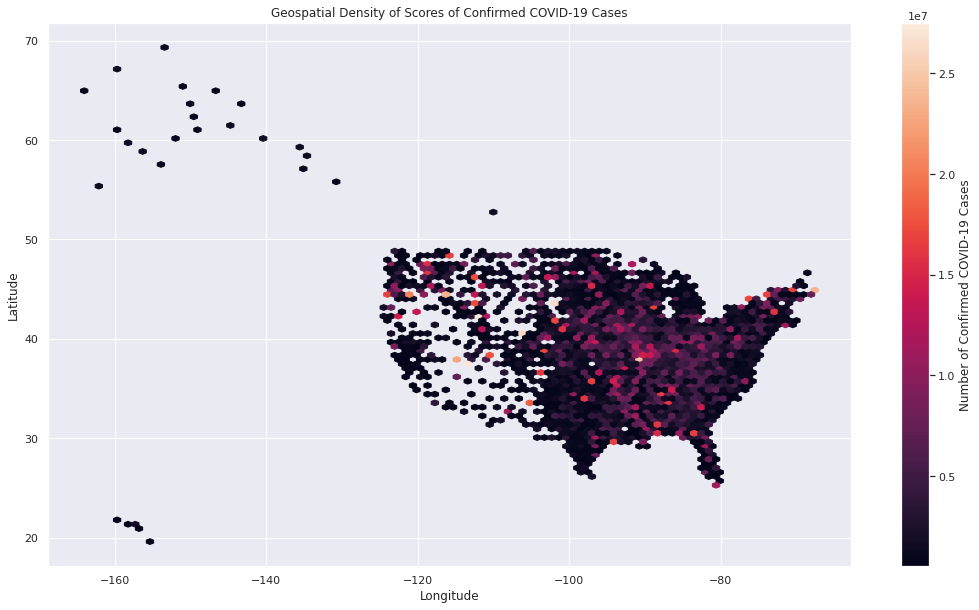

In [15]:
min_lon = locations['Longitude'].min()
max_lon = locations['Longitude'].max()
min_lat = locations['Latitude'].min()
max_lat = locations['Latitude'].max()
bound = ((min_lon, max_lon, min_lat, max_lat))
min_lon, max_lon, min_lat, max_lat

fig, ax = plt.subplots(figsize = (18,10))

mapped = plt.hexbin(x=np.array(locations["Longitude"]), y=np.array(locations["Latitude"]), 
           C = np.array(locations["Confirmed_Cases"]), reduce_C_function = np.mean)
fig.colorbar(mapped, orientation = "vertical").set_label("Number of Confirmed COVID-19 Cases", rotation = 90)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geospatial Density of Scores of Confirmed COVID-19 Cases")
plt.show()

This information was helpful in that it allowed us to view the general distribution of confirmed COVID-19 cases across the United States with points representing the density of the number of confirmed cases for each county. It appears that while most counties have a similar range of confirmed cases in this time period, the counties located in the Northeast United States have a higher overall number of confirmed cases. It can be noted that, in the Western United States, there are counties present with almost no cases confirmed, most likely in rural regions. There are also outlier counties with very high numbers of confirmed cases dispersed throughout the plot. 

However, we wanted to create a more specific and concrete visualization to better examine the spread of the virus. In order to track the spread, we wanted to plot the number of confirmed cases per day, per county. We extracted the date attributes from the spread DataFrame to reflect this. 

Note that we made copies since we do not want to change the original relations.

In [16]:
sample = spread.copy().iloc[:, 14:]
sample['County Name'] = spread["CountyName"]
sample.head(10)

,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,...,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,County Name
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,5.000000,7.00,7.000000,9.000000,9.000000,9.000000,9.000000,10.000000,10.000000,10.000000,15.000000,17.000000,17.000000,17.000000,22.000000,23.000000,24.000000,24.000000,27.000000,29.000000,29.000000,29.000000,31.0,31.000000,31.000000,33.000000,33.00,33.000000,33.000000,34.00,34.000000,34.00,34.000000,34.00,34.000000,34.0,34.0,34.00,Abbeville
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,82.0,86.000000,89.00,94.000000,98.000000,99.000000,101.000000,104.000000,105.000000,108.000000,110.000000,110.000000,110.000000,114.000000,114.000000,117.000000,117.000000,129.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.0,133.000000,133.000000,134.000000,134.00,136.000000,140.000000,142.00,142.000000,151.00,148.000000,152.00,152.000000,151.0,159.0,189.00,Acadia
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.0,11.000000,11.00,12.000000,15.000000,15.000000,15.000000,15.000000,15.000000,19.000000,28.000000,33.000000,42.000000,52.000000,52.000000,59.000000,76.000000,100.000000,146.000000,187.000000,195.000000,223.000000,229.000000,264.0,303.000000,353.000000,400.000000,425.00,429.000000,433.000000,463.00,463.000000,496.00,508.000000,524.00,530.000000,545.0,593.0,648.00,Accomack
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,419.0,438.000000,447.00,495.000000,513.000000,517.000000,517.000000,538.000000,538.000000,567.000000,576.000000,593.000000,598.000000,598.000000,616.000000,622.000000,635.000000,642.000000,650.000000,650.000000,650.000000,662.000000,662.000000,671.0,681.000000,705.000000,705.000000,710.00,713.000000,717.000000,721.00,721.000000,731.00,733.000000,739.00,744.000000,744.0,759.0,759.00,Ada
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,10.000000,10.75,11.000000,11.250000,12.500000,12.500000,21.000000,21.250000,21.750000,21.750000,22.250000,27.250000,28.250000,28.500000,30.500000,31.500000,36.500000,37.500000,37.750000,36.250000,39.000000,39.000000,39.5,39.750000,39.750000,39.750000,39.75,40.250000,41.250000,42.00,42.750000,43.75,43.750000,43.75,44.250000,44.5,46.0,46.75,Adair
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,41.5,44.916667,47.50,55.166667,62.166667,72.666667,77.916667,82.666667,82.916667,86.833333,91.333333,98.166667,105.333333,106.083333,113.916667,117.916667,123.416667,140.083333,145.416667,150.333333,155.583333,160.333333,166.833333,177.0,187.166667,194.166667,198.666667,202.00,207.916667,214.583333,223.25,229.666667,237.75,241.166667,245.25,249.166667,254.5,261.5,269.25,Adams
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

We aggregated the DataFrame to have each date represented per county along with the number of total confirmed cases for that date; we converted the Date column to be in DateTime format for uniformity.

In [17]:
sample2 = sample.melt(id_vars=['County Name'], var_name="Date", value_name="Confirmed Number").sort_values("Confirmed Number", ascending = False)
sample2['Date'] = pd.to_datetime(sample2['Date'])
sample3 = sample2[["County Name", "Confirmed Number"]].groupby("County Name").sum().sort_values("Confirmed Number", ascending=False).head(25).reset_index()
top = list(sample3["County Name"])
sample2 = sample2[sample2["County Name"].isin(top)].groupby("Date")
sample2.head(5)

,County Name,Date,Confirmed Number
183071,New York,2020-05-15,190357.0
181431,New York,2020-05-14,188545.0
179791,New York,2020-05-13,187250.0
178151,New York,2020-05-12,186123.0
176511,New York,2020-05-11,185357.0
...,...,...,...
57328,Westchester,2020-02-28,0.0
57894,Fairfield,2020-02-29,0.0
48755,Providence,2020-02-23,0.0
49685,Essex,2020-02-24,0.0


The following plot depicts the 25 counties with the largest number of confirmed cases since Jan 25th 2020.

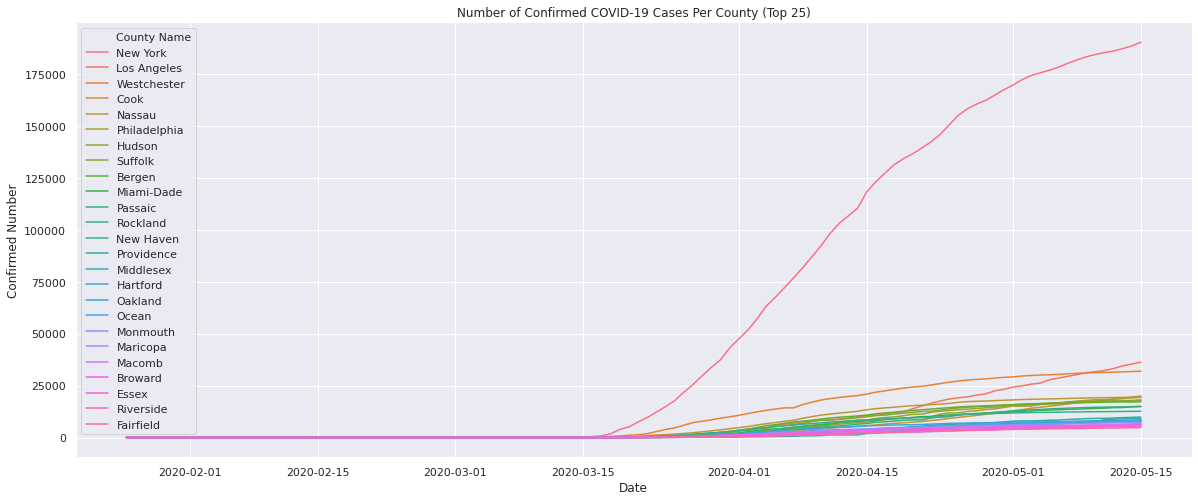

In [18]:
plt.figure(figsize=(20,8))
num_plt = sample2.head(25)
plt.title('Number of Confirmed COVID-19 Cases Per County (Top 25)')
ax = sns.lineplot("Date", "Confirmed Number", data = num_plt, hue = "County Name")

Based on this line graph, it is evident that New York County, which consists of the Manhattan district of New York, has the greatest number of confirmed COVID-19 cases out of all American counties with a drastic difference. Los Angeles county has the second greatest number of confirmed cases, followed by Westchester County. Manhattan is the most densely populated of New York City’s 5 boroughs and Los Angeles is also a crowded urban region, so transmission is more likely to occur, and may occur at a faster rate due to overcrowding and congestion, which is why these results make logical sense.

Since it may not be as uniform or impartial to determine trends in the data based on the average number of confirmed cases, we decided to quantify the number of confirmed cases in relation to the population size of the county. We did so by deriving the proportion, p = x / n, where x represents the number of successes (the average number of confirmed cases) and n represents the sample size (the population size of the county). 

In [19]:
sample4 = spread.copy()
sample4.rename(columns = {"PopulationEstimate2018": "Population"}, inplace = True)
sample4 = sample4.drop(sample4.columns[range(2,14)], axis = 1)
sample4.iloc[:,2:] = sample4.iloc[:,2:].div(sample4.Population, axis=0)
sample4 = sample4.drop("Population", axis = 1).rename(columns = {"CountyName": "County Name"})
sample4.head(5)

,County Name,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,...,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20
0,Abbeville,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000244,0.000204,0.000204,0.000285,0.000285,0.000367,0.000367,0.000367,0.000367,0.000407,0.000407,0.000407,0.000611,0.000693,0.000693,0.000693,0.000896,0.000937,0.000978,0.000978,0.001100,0.001182,0.001182,0.001182,0.001263,0.001263,0.001263,0.001345,0.001345,0.001345,0.001345,0.001385,0.001385,0.001385,0.001385,0.001385,0.001385,0.001385,0.001385,0.001385
1,Acadia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001270,0.001319,0.001383,0.001431,0.001511,0.001576,0.001592,0.001624,0.001672,0.001688,0.001737,0.001769,0.001769,0.001769,0.001833,0.001833,0.001881,0.001881,0.002074,0.002090,0.002090,0.002090,0.002090,0.002090,0.002090,0.002139,0.002139,0.002155,0.002155,0.002187,0.002251,0.002283,0.002283,0.002428,0.002380,0.002444,0.002444,0.002428,0.002557,0.003039
2,Accomack,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000339,0.000339,0.000339,0.000339,0.000370,0.000463,0.000463,0.000463,0.000463,0.000463,0.000586,0.000864,0.001018,0.001296,0.001604,0.001604,0.001820,0.002345,0.003085,0.004505,0.005769,0.006016,0.006880,0.007065,0.008145,0.009348,0.010891,0.012341,0.013112,0.013236,0.013359,0.014285,0.014285,0.015303,0.015673,0.016167,0.016352,0.016815,0.018296,0.019993
3,Ada,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000855,0.000892,0.000932,0.000951,0.001053,0.001092,0.001100,0.001100,0.001145,0.001145,0.001206,0.001226,0.001262,0.001272,0.001272,0.001311,0.001323,0.001351,0.001366,0.001383,0.001383,0.001383,0.001409,0.001409,0.001428,0.001449,0.001500,0.001500,0.001511,0.001517,0.001526,0.001534,0.001534,0.001555,0.001560,0.001572,0.001583,0.001583,0.001615,0.001615
4,Adair,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000461,0.000543,0.000543,0.000583,0.000597,0.000611,0.000678,0.000678,0.001140,0.001153,0.001180,0.001180,0.001208,0.001479,0.001533,0.001547,0.001655,0.001710,0.001981,0.002035,0.002049,0.001967,0.002117,0.002117,0.002144,0.002157,0.002157,0.002157,0.002157,0.002185,0.002239,0.002280,0.002320,0.002375,0.002375,0.002375,0.002402,0.002415,0.002497,0.002537


We aggregated the DataFrame to have each date represented per county along with the number of total proportion confirmed cases for that date.

In [20]:
sample5 = sample4.melt(id_vars=['County Name'], var_name="Date", value_name="Confirmed Proportion").sort_values("Confirmed Proportion", ascending = False)
sample5['Date'] = pd.to_datetime(sample5['Date'])
sample6 = sample5[["County Name", "Confirmed Proportion", "Date"]].groupby("County Name").sum()
sample6["Confirmed Proportion"] = sample6["Confirmed Proportion"] / 111
sample6 = sample6.sort_values("Confirmed Proportion", ascending=False).head(25).reset_index()
top2 = list(sample6["County Name"])
sample5 = sample5[sample5["County Name"].isin(top2)].groupby("Date")
sample5.head(5)

,County Name,Date,Confirmed Proportion
181882,Trousdale,2020-05-14,0.125499
183522,Trousdale,2020-05-15,0.125499
180242,Trousdale,2020-05-13,0.125409
178602,Trousdale,2020-05-12,0.123865
176962,Trousdale,2020-05-11,0.123774
...,...,...,...
60102,Ocean,2020-03-01,0.000000
60071,New York,2020-03-01,0.000000
62248,Westchester,2020-03-02,0.000000
62128,Terrell,2020-03-02,0.000000


The following plot depicts the 25 counties with the largest proportion of confirmed cases relative to their population sizes, since Jan 25th 2020.

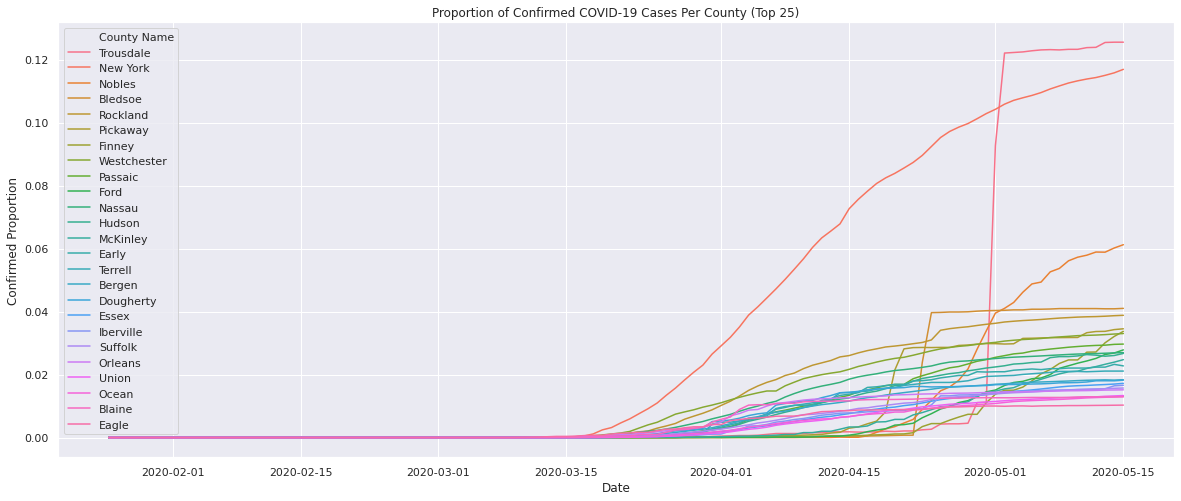

In [21]:
highest_rate_plt = sample5.head(25)
plt.figure(figsize=(20,8))
plt.title('Proportion of Confirmed COVID-19 Cases Per County (Top 25)')
ax = sns.lineplot("Date", "Confirmed Proportion", data = highest_rate_plt, hue = "County Name")

While the results were somewhat similar to the previous part in that New York county and Westchester County are in the top 10 spots for greatest proportion of confirmed COVID-19 cases based on the population, the data portrays a peculiar trend with Trousdale County taking the lead as of May 1st, 2020. This sharp increase in the proportion of confirmed cases leads me to believe this may be a discrepancy in data collection since this drastic change in the pattern of the data does not make logical sense. However, Trousdale County is a fairly small county in Tennessee, with a population size of about 7,816, which may justify this pattern since a smaller value for population size would lead to a larger proportion value with the roughly the same value for number of confirmed cases.

**Logistic Regression**

In order to predictively examine the relationship between the number of confirmed cases and social-distancing and other precautionary policies and guidelines, we developed a linear regression model. 

First, we performed a train_test_split which split our data so that 10% was allocated for testing our model and 90% was allocated for training our model.


In [0]:
county, countytest = train_test_split(counties, test_size=0.1, random_state=42)
states, statestest = train_test_split(states, test_size=0.1, random_state=42)
cases, casestest = train_test_split(confirmed, test_size=0.1, random_state=42)
deaths, deathstest = train_test_split(deaths, test_size=0.1, random_state=42)

We merged the death and counties relations. Then, we renamed the county name for
easier identification and set it as the index. Finally, we grouped by the county
name in order to obtain unique values and aggregate with the np.mean function to obtain county averages for each quantitative attribute. countyCASES and countyDEATHS are the same but are cases vs deaths respectively. 

In [0]:
countyCASESmerged = cases.merge(counties, how='inner', left_on='Admin2', right_on='CountyName').rename(columns = {"Admin2" : "County Name"}).set_index('County Name').fillna(0).groupby('County Name').agg(np.mean)
countyDEATHSmerged = deaths.merge(counties, how='inner', left_on='Admin2', right_on='CountyName').rename(columns = {"Admin2" : "County Name"}).set_index('County Name').fillna(0).groupby('County Name').agg(np.mean)

In this cell, we removed most of our rows. Viruses grow exponentially, but they also take some time to spread. Since coronavirus symptoms can take weeks to show, we removed all counties from our data that had 0 cases on or before March 18, 2020. This is because our data only goes up until April 18, and less than 1 month is not quite enough time for the exponential growth of coronavrirus to be apparent. We wanted our indexes for cases and deaths to match, so we deleted all the rows from countyDEATHS that we deleted in countyCASES.

In [0]:
countyCASES = countyCASESmerged.copy().reset_index()
countyDEATHS = countyDEATHSmerged.copy().reset_index()
listofrowstodrop = []
i = 0
if all(countyCASES.index == countyDEATHS.index):
  for x in countyCASES['3/18/20']:
    if x == 0:
      countyCASES = countyCASES.drop([i])
      countyDEATHS = countyDEATHS.drop([i])
      i += 1
    else:
      i += 1

countyCASES = countyCASES.set_index('County Name')
countyDEATHS = countyDEATHS.set_index('County Name')

This cell shows the first 5 cells of the data frame percounty. It is conveniently indexed by county and had the method groupby performed so that each row corresponds to exactly one county. 

In [25]:
if all(countyCASES.index == countyDEATHS.index):
  print('countyCASES and countyDEATHS have matching indexes, where the index of each df is County Name') 

countyCASES and countyDEATHS have matching indexes, where the index of each df is County Name


Here we observed the first 5 counties in our countyCASES DataFrame. 


In [26]:
countyCASES.head(5)

,UID,code3,FIPS,Lat,Long_,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,...,PopMale30-342010,PopFmle30-342010,PopMale35-442010,PopFmle35-442010,PopMale45-542010,PopFmle45-542010,PopMale55-592010,PopFmle55-592010,PopMale60-642010,PopFmle60-642010,PopMale65-742010,PopFmle65-742010,PopMale75-842010,PopFmle75-842010,PopMale>842010,PopFmle>842010,3-YrMortalityAge<1Year2015-17,3-YrMortalityAge1-4Years2015-17,3-YrMortalityAge5-14Years2015-17,3-YrMortalityAge15-24Years2015-17,3-YrMortalityAge25-34Years2015-17,3-YrMortalityAge35-44Years2015-17,3-YrMortalityAge45-54Years2015-17,3-YrMortalityAge55-64Years2015-17,3-YrMortalityAge65-74Years2015-17,3-YrMortalityAge75-84Years2015-17,3-YrMortalityAge85+Years2015-17,mortality2015-17Estimated,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,SVIPercentile,HPSAShortage,HPSAServedPop,HPSAUnderservedPop
County Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ada,8.401600e+07,840.0,16001.000000,43.452658,-116.241552,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14523.000000,13868.000000,28636.00,27189.000000,27570.000000,27511.0,11621.00,11995.000000,9788.00,9912.00,10818.00,11971.000000,5271.0,7143.00,1997.0,3848.000000,22.000000,0.0,0.0,31.000000,61.000000,74.000000,163.000000,367.00,520.00,693.000000,1097.0,0.000000,737509.00,737509.00,737509.000000,737507.000000,737507.0,737507.000000,737500.0,737495.0,0.137300,0.000000,0.0,0.00
Adair,8.402725e+07,840.0,27251.000000,38.627720,-91.752932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,472.500000,473.000000,1071.25,1058.500000,1258.500000,1270.5,570.00,565.750000,500.25,515.25,706.25,767.750000,347.5,481.75,118.0,240.500000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,12.250000,26.25,39.75,51.750000,52.0,0.000000,368757.75,737511.25,737511.250000,737505.250000,737505.5,737510.000000,737500.0,737495.0,0.529300,1.977200,6461.0,5938.50
Adams,8.403164e+07,840.0,31637.545455,40.854991,-94.232650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2350.583333,2223.416667,4591.00,4337.083333,4595.916667,4526.5,1955.25,1974.583333,1597.50,1679.50,1971.25,2238.833333,1077.0,1426.00,331.0,669.833333,3.083333,0.0,0.0,4.833333,10.083333,14.916667,34.416667,71.00,104.75,133.333333,162.5,0.000000,553132.50,676047.50,676044.666667,737503.833333,737504.0,737504.333333,737500.0,737495.0,0.471092,1.289125,5556.0,3672.75
Addison,8.405000e+07,840.0,50001.000000,44.032173,-73.141309,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,889.000000,889.000000,2191.00,2368.000000,3024.000000,3001.0,1444.00,1488.000000,1240.00,1265.00,1411.00,1415.000000,675.0,878.00,250.0,473.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,14.000000,33.00,55.00,72.000000,131.0,0.000000,737509.00,737509.00,737509.000000,737502.000000,737501.0,737507.000000,737500.0,737495.0,0.096500,0.000000,0.0,0.00
Alameda,8.400600e+07,840.0,6001.000000,37.646294,-121.892927,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,56256.000000,58351.000000,113021.00,114470.000000,109599.000000,113018.0,45580.00,49068.000000,37509.00,41345.00,41628.00,48809.000000,21761.0,30815.00,8267.0,16466.000000,72.000000,0.0,14.0,116.000000,186.000000,264.000000,594.000000,1267.00,1734.00,2135.000000,3535.0,559.341157,

Here we observed the first 5 counties in our counyDEATHS DataFrame.

In [27]:
countyDEATHS.head(5)

,UID,code3,FIPS,Lat,Long_,Population,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,...,PopMale30-342010,PopFmle30-342010,PopMale35-442010,PopFmle35-442010,PopMale45-542010,PopFmle45-542010,PopMale55-592010,PopFmle55-592010,PopMale60-642010,PopFmle60-642010,PopMale65-742010,PopFmle65-742010,PopMale75-842010,PopFmle75-842010,PopMale>842010,PopFmle>842010,3-YrMortalityAge<1Year2015-17,3-YrMortalityAge1-4Years2015-17,3-YrMortalityAge5-14Years2015-17,3-YrMortalityAge15-24Years2015-17,3-YrMortalityAge25-34Years2015-17,3-YrMortalityAge35-44Years2015-17,3-YrMortalityAge45-54Years2015-17,3-YrMortalityAge55-64Years2015-17,3-YrMortalityAge65-74Years2015-17,3-YrMortalityAge75-84Years2015-17,3-YrMortalityAge85+Years2015-17,mortality2015-17Estimated,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,SVIPercentile,HPSAShortage,HPSAServedPop,HPSAUnderservedPop
County Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ada,8.401600e+07,840.0,16001.000000,43.452658,-116.241552,481587.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14523.000000,13868.000000,28636.00,27189.000000,27570.000000,27511.0,11621.00,11995.000000,9788.00,9912.00,10818.00,11971.000000,5271.0,7143.00,1997.0,3848.000000,22.000000,0.0,0.0,31.000000,61.000000,74.000000,163.000000,367.00,520.00,693.000000,1097.0,0.000000,737509.00,737509.00,737509.000000,737507.000000,737507.0,737507.000000,737500.0,737495.0,0.137300,0.000000,0.0,0.00
Adair,8.402725e+07,840.0,27251.000000,38.627720,-91.752932,18472.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,472.500000,473.000000,1071.25,1058.500000,1258.500000,1270.5,570.00,565.750000,500.25,515.25,706.25,767.750000,347.5,481.75,118.0,240.500000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,12.250000,26.25,39.75,51.750000,52.0,0.000000,368757.75,737511.25,737511.250000,737505.250000,737505.5,737510.000000,737500.0,737495.0,0.529300,1.977200,6461.0,5938.50
Adams,8.403164e+07,840.0,31637.545455,40.854991,-94.232650,77947.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2350.583333,2223.416667,4591.00,4337.083333,4595.916667,4526.5,1955.25,1974.583333,1597.50,1679.50,1971.25,2238.833333,1077.0,1426.00,331.0,669.833333,3.083333,0.0,0.0,4.833333,10.083333,14.916667,34.416667,71.00,104.75,133.333333,162.5,0.000000,553132.50,676047.50,676044.666667,737503.833333,737504.0,737504.333333,737500.0,737495.0,0.471092,1.289125,5556.0,3672.75
Addison,8.405000e+07,840.0,50001.000000,44.032173,-73.141309,36777.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,889.000000,889.000000,2191.00,2368.000000,3024.000000,3001.0,1444.00,1488.000000,1240.00,1265.00,1411.00,1415.000000,675.0,878.00,250.0,473.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,14.000000,33.00,55.00,72.000000,131.0,0.000000,737509.00,737509.00,737509.000000,737502.000000,737501.0,737507.000000,737500.0,737495.0,0.096500,0.000000,0.0,0.00
Alameda,8.400600e+07,840.0,6001.000000,37.646294,-121.892927,1671329.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,56256.000000,58351.000000,113021.00,114470.000000,109599.000000,113018.0,45580.00,49068.000000,37509.00,41345.00,41628.00,48809.000000,21761.0,30815.00,8267.0,16466.000000,72.000000,0.0,14.0,116.000000,186.000000,264.000000,594.000000,1267.00,1734.00

Both of our dataframes have columns that correspond to dates from 1/22/20 to 4/18/20. We assigned dates to LIST of the column names so we can call df[dates] in the future. df[dates] will return df with only the time trend columns.

In [0]:
dates = np.array(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
'1/28/20', '1/29/20', '1/30/20', '1/31/20', '2/1/20', '2/2/20',
'2/3/20', '2/4/20', '2/5/20', '2/6/20', '2/7/20', '2/8/20',
'2/9/20', '2/10/20', '2/11/20', '2/12/20', '2/13/20', '2/14/20',
'2/15/20', '2/16/20', '2/17/20', '2/18/20', '2/19/20', '2/20/20',
'2/21/20', '2/22/20', '2/23/20', '2/24/20', '2/25/20', '2/26/20',
'2/27/20', '2/28/20', '2/29/20', '3/1/20', '3/2/20', '3/3/20',
'3/4/20', '3/5/20', '3/6/20', '3/7/20', '3/8/20', '3/9/20',
'3/10/20', '3/11/20', '3/12/20', '3/13/20', '3/14/20', '3/15/20',
'3/16/20', '3/17/20', '3/18/20', '3/19/20', '3/20/20', '3/21/20',
'3/22/20', '3/23/20', '3/24/20', '3/25/20', '3/26/20', '3/27/20',
'3/28/20', '3/29/20', '3/30/20', '3/31/20', '4/1/20', '4/2/20',
'4/3/20', '4/4/20', '4/5/20', '4/6/20', '4/7/20', '4/8/20',
'4/9/20', '4/10/20', '4/11/20', '4/12/20', '4/13/20', '4/14/20',
'4/15/20', '4/16/20', '4/17/20', '4/18/20'], dtype='<U7').tolist()

Then, we performed a train_test_split on the two DataFrames we constructed earlier. Note that data was randomized and is no longer be in the same order

In [29]:
countyCASEStrain, countyCASEStest = train_test_split(countyCASES, test_size=0.1, random_state=42)
countyDEATHStrain, countyDEATHStest = train_test_split(countyDEATHS, test_size=0.1, random_state=42)
print('There are '+str(countyCASEStrain.shape[0])+ ' counties in the training set and '+str(countyCASEStest.shape[0])+ ' counties in the testing set.')

There are 388 counties in the training set and 44 counties in the testing set.


In this cell, we made two 2 dimensional matrices, casesovertimex and casesovertimey. They are to be inputted as parameters into plt.scatter so we can create a scatter diagram of all the cases in our time series. We created an iterable set of numbers in chronological order, increasing by 1, where the last value of the set is equal to the number of rows or columns in the casesbydatearray dataframe.

In [0]:
numrows = np.arange(0, countyCASEStrain.shape[0], 1)
numcolumns = np.arange(0, countyCASEStrain.shape[1], 1)

This is a 2-D matrix with the shape of casesbydatearra, but where every column has the same value. 

In [0]:
listxmatrix = []
for x in numrows:
  listxmatrix.append(numcolumns)
  
xdf = pd.DataFrame(listxmatrix,columns=numcolumns, index=numrows)
xmatrix = xdf.to_numpy()

This is the data for the linear scale.

In [0]:
ylineardf = pd.DataFrame(countyCASEStrain)

This is the data for the log scale.

In [33]:
ylogdf = pd.DataFrame(countyCASEStrain)
ylogdf = ylogdf.replace(0, np.nan)
ylogdf = ylogdf.set_index(numrows)
ylogdf = ylogdf.applymap(np.log)
ylogdf = ylogdf.replace(np.nan, 0)
ylogmatrix = ylogdf.to_numpy()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6942: RuntimeWarning:

invalid value encountered in log



This is a visualization using matplotlib, using linear scale.

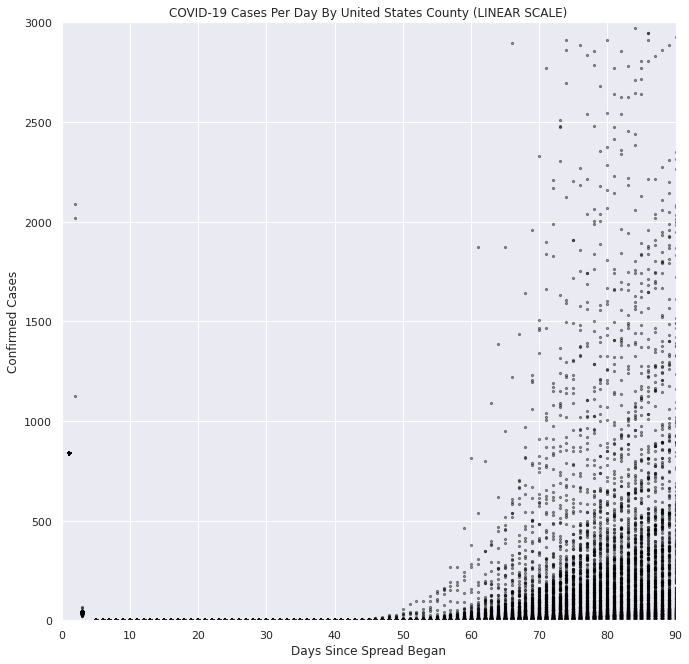

In [34]:
colors = cm.rainbow(np.linspace(0, 1, len(ylineardf)))
fig, ax = plt.subplots(figsize = (11,11))
ax.set_xlim(0,90)
ax.set_ylim(0,3000)

plt.scatter(x=xmatrix, y=ylineardf, c='black' ,s=5, alpha=0.4)
plt.yscale('linear')
plt.title('COVID-19 Cases Per Day By United States County (LINEAR SCALE)')
plt.xlabel('Days Since Spread Began')
plt.ylabel('Confirmed Cases')
plt.show()

This is a visualization using matplotlib, using log scale.

Text(0, 0.5, 'Confirmed Cases')

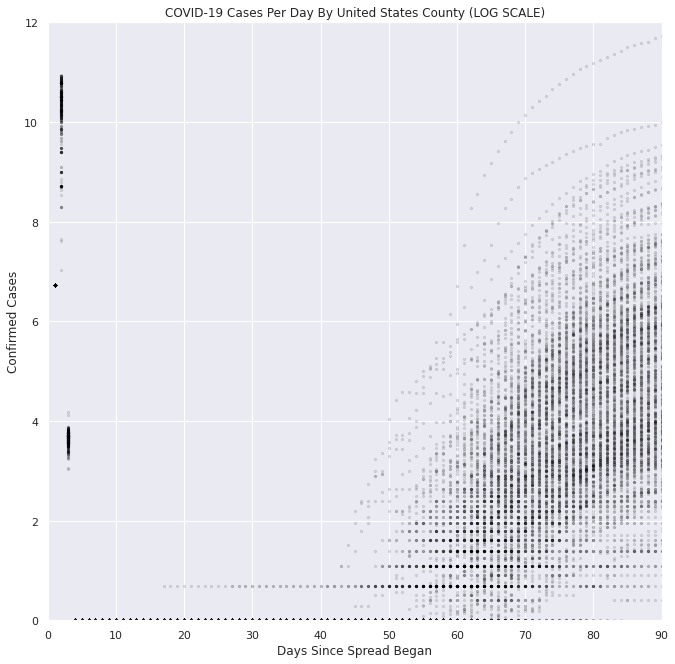

In [35]:
fig, ax = plt.subplots(figsize = (11,11))
ax.set_xlim(0,90)
ax.set_ylim(0,12)

plt.scatter(x=xmatrix, y=ylogmatrix, c='black', s=5,alpha=0.1)
plt.yscale('linear')
plt.title('COVID-19 Cases Per Day By United States County (LOG SCALE)')
plt.xlabel('Days Since Spread Began')
plt.ylabel('Confirmed Cases')

In this cell, we built the DataFrame which we eventually use to train our model. The model aims to predict the next 2 weeks of cases-per-day data 

In [36]:
def featuredf(cases, states):
################MATRIX FOR TIME SERIES FEATURES############################
  featuredf = cases[dates]
  featuredf = featuredf.set_axis(np.arange(0,len(dates), 1), axis=1, inplace=False)
  featuredf = featuredf.iloc[:,:-7]
#######NEW COLUMN THAT CONTAINS A LIST OF THE NEXT 14 DAYS OF CASES########
  return featuredf  

predict1day = featuredf(cases, states)
#last14days = predict1day[np.arange(len(dates)-14, len(dates), 1)].to_numpy()
predict1day.transpose()

,1053,1612,1815,3022,1017,430,596,1726,1084,2685,188,1456,1830,439,2582,495,1740,1222,324,2566,3125,246,450,2316,1225,1608,2986,2815,1018,602,2787,2748,2353,1897,2144,2813,1385,2123,2304,874,...,3005,189,1806,975,2747,2047,2558,1082,474,2904,747,2300,21,459,1184,2324,955,1215,2433,2853,1515,2391,769,1685,130,2919,3171,2135,1482,330,1238,466,2169,1638,3092,1095,1130,1294,860,3174
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,319,0,2,5,0,2,5,0,6,0,27,7,7,111,0,8,0,405,1211,1,0,243,3,27,0,0,166,0,2,3,158,38,2,2,40,8,0,110,7,0,...,0,1,0,0,517,5,101,0,6,1,25,136,7,6,253,75,9,46,11,532,3,0,7,7,1,25,118,5,5,2230,18,194,1,0,1323,1,13,16,6,0
77,319,0,2,5,0,3,5,0,6,0,27,7,7,122,0,12,0,423,1440,1,0,263,3,31,0,0,169,0,2,3,163,38,2,2,40,8,0,114,7,0,...,0,1,0,0,588,5,108,0,13,1,28,148,7,8,262,75,11,62,11,570,3,0,7,7,1,25,126,5,5,2358,18,215,1,0,1416,1,14,18,6,0
78,380,0,2,5,0,3,6,0,7,0,27,8,7,127,0,12,0,444,1523,1,0,274,3,31,0,0,172,1,2,4,170,51,3,2,48,8,0,120,7,0,...,0,1,0,0,637,6,118,0,13,1,30,163,7,7,269,96,11,65,11,690,5,0,7,7,4,25,131,8,6,2454,18,225,1,0,1484,1,17,19,6,0
79,380,0,4,6,0,3,6,0,7,0,27,10,8,142,0,14,0,464,1660,1,0,298,3,37,0,0,178,1,2,4,180,55,3,2,52,8,0,125,10,0,...,0,1,0,0,705,6,147,0,14,1,31,190,8,13,276,100,11,71,11,777,4,0,8,7,4,25,137,9,7,2645,19,242,1,0,1575,1,18,20,6,0


First we wrote best_y_train, which is a dataframe with the last 7 columns labeled 1-7.

In [37]:
casestestcopy = casestest.copy()
best_Y_train = cases[dates[-7:]]
best_Y_train = best_Y_train.rename(columns={'4/12/20': 1, '4/13/20': 2, '4/14/20': 3, '4/15/20': 4, '4/16/20': 5, '4/17/20': 6, '4/18/20': 7, '4/19/20': 8})
casestestcopy = casestestcopy.rename(columns={'4/12/20': 1, '4/13/20': 2, '4/14/20': 3, '4/15/20': 4, '4/16/20': 5, '4/17/20': 6, '4/18/20': 7, '4/19/20': 8})
day1 = best_Y_train[1]
best_X_train = featuredf(cases, states).to_numpy()

best_X_test = featuredf(casestest, countytest).to_numpy()
testmodel = LogisticRegression()
testmodel.fit(best_X_train, day1)
testpredictedfinal = testmodel.predict(best_X_test)
testtruevalues = casestestcopy[1]

d = {'Predicted Cases': testpredictedfinal, 'Actual Cases': testtruevalues}
modelaccuracy = pd.DataFrame(data=d)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



As we know, viruses grow exponentially. Therefore, we applied log to every element of the dataframe when we call slopeandinterceptfeature on it. Then, the slopeandinterceptfeature function uses linear regression to calculate the slope and intercept. The slope and intercepts are added to the dataframe as columns named 'slope' and 'intercept.'

However, we wanted to undo the log we applied on the data earlier in this cell, so we wrote a short function that undoes the log we applied to our data earlier. 
$$ x(t) = a * b^t $$ 
s.t. x(t) = number of cases at any given time t and 
a = number of cases at the beginning, also called initial value
$$ y = m*x + b $$ 
$$ log(x(t)) = log(a) + tlog(b) $$ 

In [0]:
def applyexponential(df, columnnames):
  for x in columnnames:
    df[x] = np.exp(df[x])
  return df

We used another function to obtain slopes and intercepts from each row in the DataFrame so we could predict these for new data by using other features. This function takes in the case-by-day time series DataFrame. NOTE: The DataFrame should include columns in the date list defined above. NOTE: If you want the data to return a list of the DataFrames: intercept: slopeandinterceptfeature(df)['intercept'] and slope: slopeandinterceptfeature(df)['slope'].

In [0]:
def slopeandinterceptfeature(df):
  countynames = df.index
  ogdata = df.copy()
  df = df[dates]
  slope = []
  intercept = []
  dfnumrows = df.shape[0]
  df = df.transpose().reset_index(drop=True)
  df.columns = np.arange(df.shape[1])
  columns = np.array([np.arange(0, df.shape[0], 1)] * df.shape[1]).transpose()
  columns = pd.DataFrame(columns, columns = np.arange(df.shape[1]))
  x_data = columns.replace(0, np.nan).applymap(np.log).replace(np.nan, 0)
  y_data = df.replace(0, np.nan).applymap(np.log).replace(np.nan, 0)
  for x in np.arange(dfnumrows):
    curve_fit = np.polyfit(x_data[x], y_data[x], 1)
    slope.append(curve_fit[0])
    intercept.append(curve_fit[1])
  df = df.transpose()
  ogdata['growth factor'] = slope
  ogdata['initial value'] = intercept
  ogdata['County Name'] = countynames
  return applyexponential(ogdata, ['growth factor', 'initial value'])

We obtained a list of features that we use to fit and train our model. Note that the last two elements of this list must be 'slope' and 'intercept' as these are the features we are trying to predict.

In [0]:
listoffeatures = ['PopulationDensityperSqMile2010','PopulationEstimate2018','stay at home','>50 gatherings', '>500 gatherings', 'public schools', 'restaurant dine-in', 'entertainment/gym', 
                  'federal guidelines', 'foreign travel ban', 'growth factor', 'initial value']
list2features = ['PopulationDensityperSqMile2010','PopulationEstimate2018','stay at home', '>50 gatherings', '>500 gatherings', 'public schools', 'restaurant dine-in', 'entertainment/gym', 
                 'federal guidelines', 'foreign travel ban']

We created a function will return a DataFrame that will be ready to be inputted into our model. It returns a dataframe with all the necessary features (up to the user's discretion, can be changed depending on what you put into the list, listoffeatures. Note: the parameter traindata must be in the same format as countyCASES, where there is one row per county and each county has time trend data.

In [41]:
def returnfeaturedf(traindata, listoffeatures):
  featuredf = slopeandinterceptfeature(traindata)
  featuredf = featuredf[listoffeatures]
  return featuredf

returnfeaturedf(countyCASEStrain, listoffeatures)

,PopulationDensityperSqMile2010,PopulationEstimate2018,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,growth factor,initial value
County Name,,,,,,,,,,,,
Berkshire,141.600000,1.263480e+05,737508.0,737501.000000,737501.000000,737501.000000,737501.00,737501.000000,737500.0,737495.0,5.093646,0.026067
Douglas,257.491667,1.245866e+05,614592.5,676045.583333,676043.666667,737501.916667,737504.75,676046.916667,737500.0,737495.0,2.749342,0.094258
Pearl River,68.900000,5.538700e+04,737521.0,737509.000000,737509.000000,737504.000000,737509.00,737509.000000,737500.0,737495.0,3.016044,0.079140
Chelan,24.800000,7.703600e+04,737507.0,737507.000000,737495.000000,737501.000000,737501.00,737501.000000,737500.0,737495.0,2.499608,0.119498
McCook,9.800000,5.546000e+03,0.0,0.000000,0.000000,737500.000000,737507.00,0.000000,737500.0,737495.0,1.224579,0.624777
...,...,...,...,...,...,...,...,...,...,...,...,...
Charles Mix,8.300000,9.338000e+03,0.0,0.000000,0.000000,737500.000000,737507.00,0.000000,737500.0,737495.0,1.192469,0.652489
Cuyahoga,2800.000000,1.243857e+06,737507.0,737499.000000,737499.000000,737501.000000,737499.00,737506.000000,737500.0,737495.0,7.331364,0.011410
Nevada,58.850000,5.401100e+04,368751.5,737506.500000,737506.500000,737502.000000,737501.00,737501.000000,737500.0,737495.0,1.832903,0.236637


Let's see if we can predict cases per day of coronavirus in ORANGE COUNTY, CA. In this cell, we performed our first prediction. Let's see how accurate our model can be at predicting a county's growth facter and initial value based ONLY on population and 'Smokers_Percentage.' We made a model named graphmodelprediction that graphs a predicted coronavirus cases-per-day model given a list of features, the TRAINING data, as well as a SINGLE county that we want to predict.

In [0]:
#def removespaces(df):
  #for df['CountyName'] in df: 
   # df['CountyName'] = df['CountyName'].to_string().replace(' ', '');

#removespaces(countyCASEStrain)

In [43]:
def graphmodelprediction(countyname, county, traindata, listoffeatures, list2features):
#countyname: string, name of county we are trying to predict the coronavirus spread of
#county:
#traindata: dataframe we will train on
#listoffeatures: list of features we want to consider in our model (must include 'growth factor' and 'initial value')
  featuredf = returnfeaturedf(traindata, listoffeatures)
  y_train_growthfactor = featuredf['growth factor']
  y_train_initialvalue = featuredf['initial value']
  featuredf = featuredf.drop(columns=['initial value', 'growth factor'])
  x_train = featuredf.to_numpy()

#Predict Growth Factor
  growthfactor = LinearRegression()
  growthfactor.fit(x_train, y_train_growthfactor)
  predictedgrowthfactorfinal = growthfactor.predict(county[list2features])

#Predict Initial Value
  initialvalue = LinearRegression()
  initialvalue.fit(x_train, y_train_initialvalue)
  predictedinitialvaluefinal = initialvalue.predict(county[list2features])

  def graph(func):
    x = np.arange(0.0,15.0,0.25)
    y = func(x)
    # line 1 points
    # plotting the line 1 points
    plt.plot(x, y, 'm')
    # naming the x axis
    plt.xlabel('Time') 
    # naming the y axis 
    plt.ylabel('Total Number of Infected People') 
    # giving a title to my graph
    stringname = countyname+' County COVID-19 Spread' 
    plt.title(stringname) 
    plt.xlim(0,15) 
    plt.ylim(0,10000) 
    return plt.show()
  return graph(lambda x: (predictedinitialvaluefinal[0]) * (predictedgrowthfactorfinal[0]) ** x)

graphmodelprediction('Douglas', countyCASEStest.loc[['Douglas']], countyCASEStrain, listoffeatures, list2features)

KeyError: ignored

Finally, this list of cities was inputed as the second parameter of the function, graphmultiple. These are the cities we chose to graph. Let's choose 5 random cities from our test set: 

In [44]:
counties = ['Sullivan', 'Lincoln', 'Nicollet','Shasta','Bennington']
#graph multiple will graph the cities in listofcities by iterating over the list, and running the function graphmodelprediction for every county we want to model.
def graphmultiple(testdata,listofcounties):
  for county in counties:
    graphmodelprediction(county, testdata.loc[[county]], countyCASEStrain,listoffeatures, list2features)
    timetrendtestdata = testdata.loc[[county]][dates]
    timetrendtestdata.columns = np.arange(88)
    for day in timetrendtestdata:
      if timetrendtestdata[day][0] == 0.0:
        timetrendtestdata = timetrendtestdata.drop([day], axis=1)
    timetrendtestdata.columns = np.arange(timetrendtestdata.shape[1])
    xvals = timetrendtestdata.columns.values
    yvals = np.asarray(timetrendtestdata.iloc[[0]])[0]
    plt.plot(xvals, yvals, 'c')
    string = county+' County: Cases Per Day'
    plt.title(string)
    plt.xlabel('DAYS SINCE SPREAD BEGAN')
    # naming the y axis
    plt.ylabel('REPORTED CASES')
    return plt.show()
    
graphmultiple(countyCASEStest, counties)

KeyError: ignored

## **Question 2: What is the optimum availability of hospital equipment or number of frontline hospital workers in the patient's county in order to minimize the death rate?**

In order to obtain the data we need to answer this question, such as the per-day COVID-19 death total and hospital equipment and availability, we merged the death and counties relations. We renamed the county name for easier identification. We grouped by the county name in order to obtain unique values and aggregate with the np.mean function to obtain county averages for each quantitative attribute. We named this relation, percounty. 

In [44]:
percounty = deaths.merge(counties, how='inner', left_on='Admin2', right_on='CountyName').rename(columns = {'Admin2':'County Name'}).fillna(0).groupby('County Name').agg(np.mean).reset_index()
percounty.head(5)

TypeError: ignored

We ensured that all county indices are unique (there are no duplicate county entries). 

In [0]:
len(percounty.index.unique().values) == len(percounty.index.values)

Next, we extracted the columns corresponding to hospital equipment availability from the percounty table, such as the population (for proportion calculations), the number of ICU Beds, the number of hospitals, and the number of partipating hospitals in the hospital network in 2017. We descriptively renamed these attributes for convenience in identification. After computing the average values, in the context of the data, it does not make logical sense for a county to have 1.25 of a bed or hospital, hence all values were rounded to the nearest whole number. We named this relation, hospital_equipment.


In [0]:
hospital_equipment = percounty[['County Name', 'Population', '#ICU_beds', '#Hospitals', '#HospParticipatinginNetwork2017']].rename(columns = {"#ICU_beds" : "Avg Num of ICU Beds", 
                                                                                                                               "#Hospitals" : "Avg Num of Hospitals", 
                                                                                                                               "#HospParticipatinginNetwork2017" : "Avg Num of Hospitals Participating in Network (2017)"}).round(decimals = 0) 
hospital_equipment.head(5)

Next, we added a column to hospital_equipment, in which we calculated the average number of ICU beds available in each county with respect to the population size by deriving the proportion, p = x / n, where x represents the number of successes (in this case the average number of ICU beds available) and n represents the sample size (in this case the population size). We did the same with the number of hospitals as we calculated the proportion of hospital beds with respect to the total population of a county, and added a respective column. 

In [0]:
hospital_equipment["Avg Proportion of ICU Beds Based on Population"] = hospital_equipment['Avg Num of ICU Beds'] / hospital_equipment['Population']
hospital_equipment["Avg Proportion of Hospitals Based on Population"] = hospital_equipment['Avg Num of Hospitals'] / hospital_equipment['Population']

Next, we extracted the columns corresponding to hospital worker availability from the percounty table, such as the population (for proportion calculations), the number of full-time employees at hospitals in 2017, the number of medical doctors available in 2017, the population served or unserved by FTE healthcare practitioners, and the number of these practitioners needed to achieve the appropriate Population to Practitioner target ratio. We descriptively renamed these attributes for convenience in identification. After computing the average values, in the context of the data, it does not make logical sense for a county to have 1.25 of a doctor or medical worker, hence all values were rounded to the nearest whole number. We named this relation, hospital_workers.

In [0]:
hospital_workers = percounty[['Population','County Name', '#FTEHospitalTotal2017', "TotalM.D.'s,TotNon-FedandFed2017",  'HPSAServedPop', 'HPSAUnderservedPop', 
                              'HPSAShortage']].rename(columns = {"#FTEHospitalTotal2017" : "Avg Num of Full-time Employees at Hospitals (2017)",
                                                                                           "TotalM.D.'s,TotNon-FedandFed2017" : "Avg Num of MDs (2017)",
                                                                                           "HPSAServedPop" : "Population Served by FTE Healthcare Practitioners within a HPSA",
                                                                                           "HPSAUnderservedPop" : "Population Unserved by Full-time Equivalent Healthcare Practitioners within a Health Professional Shortage Area",
                                                                                           "HPSAShortage" : "Avg Num of FTE Practitioners Needed in HPSA to Achieve Population : Practitioner Target Ratio"}).round(decimals = 0) 
hospital_workers.head(5)                                   

Next, we added a column to hospital_workers, in which we calculated the average number of medical doctors available with respect to the population by deriving the proportion, p = x / n, where x represents the number of successes (in this case the average number of medical doctors available in 2017) and n represents the sample size (in this case the population size). We did the same with the number of hospital employees as we calculated the proportion of full time hospital employees in 2017 with respect to the total population of a county, and added a respective column.  

In [0]:
hospital_workers['Avg Proportion of MDs Available Based on Population (2017)']  = hospital_workers['Avg Num of MDs (2017)'] / hospital_workers['Population']
hospital_workers['Avg Proportion of Full Time Hospital Employees Available Based on Population (2017)'] = hospital_workers['Avg Num of Full-time Employees at Hospitals (2017)'] / hospital_workers['Population']

Next, we created a dataframe based on percounty containing only the death total recorded per day from 1/22/20 to 5/11/20 (the current date). To do so, we dropped extraneous columns such as "Lat_" and "Long_", and isolated the columns corresponding to dates. After computing the average values, in the context of the data, it does not make logical sense for a county to have 1.25 deaths, hence all values were rounded to the nearest whole number. We named this relation, mortality_rate.

In [0]:
mortality_rate = percounty.drop(['UID',	'code3',	'FIPS',	'Lat',	'Long_', 'Population'], axis = 1).iloc[:, :112].round(decimals = 0)
mortality_rate.head(5)

We merged the day-to-day death toll relation with the hospital equipment relation in order to compare and contrast features. We named this relation, equipment.

In [0]:
equipment = hospital_equipment.merge(mortality_rate, left_on='County Name', right_on = 'County Name')
equipment.head(5)

We merged the day-to-day death toll relation with the hospital worker relation in order to compare and contrast features. We named this relation, workers.

In [0]:
workers = hospital_workers.merge(mortality_rate, left_on = 'County Name', right_on = 'County Name')
workers.head(5)

We restricted the equipment dataframe to counties where there was mortality due to COVID-19, i.e where the death toll is not equal to 0.

In [0]:
equipment = equipment[equipment.iloc[:, 6:].T.abs().sum() >= 0]
equipment.head(5)

We restricted the workers dataframe to counties where there was mortality due to COVID-19, i.e where the death toll is not equal to 0. 

In [0]:
workers = workers[workers.iloc[:, 8:].T.abs().sum() >= 0]
workers.head(5)

We widened the equipment dataframe and aggregated the data with the dates condensed into one column, represented by a unique index for each date and each county, as well as the number of deaths on that date in that county. 

In [0]:
equipment2 = equipment.melt(id_vars = equipment.columns[range(0,9)], var_name="Date", value_name="Deaths")
equipment2.head(5)

We widened the workers dataframe and aggregate the data with the dates condensed into one column, represented by a unique index for each date and each county, as well as the number of deaths on that date in that county. 

In [0]:
workers2 = workers.melt(id_vars = workers.columns[range(0,9)], var_name="Date", value_name="Deaths")
workers2.head(5)

We combined the refined hospital worker and equipment data into a single dataframe for convenience through exploratory data analysis; we named this relation, data.

In [0]:
data = workers2.merge(equipment2, right_on = 'County Name', left_on = 'County Name').iloc[:, :17]

In [0]:
data = data.drop(columns = {"Population_y"}).rename(columns = {"Population_x": "Population", "Date_x" : "Date", "Deaths_x" : "Deaths"})
data.head(5)

How do some of these features associated with equipment and worker availability in hospitals relate to the mortality rate within counties?

In [0]:
sns.scatterplot(data = data, x = "Avg Num of MDs (2017)", y = "Deaths");
plt.title('Relationship Between Avg Num of MDs and Mortality Rate')

Based on this visualization, we can observe that, while the spread does not have a linear or logarithmic distribution, most counties have an average number of medical doctors available in the range of between 20000 and 25000, and the mortality rate is lower when the number of MDs available within a county is lower. This trend is possibley due to the fact that there is less data on counties with a greater number of MDs available.  Also, since smaller counties have a lower count of MDs available, we can assume the mortality rate would be lower as well, respective to the population size.

In [0]:
sns.scatterplot(data = data, x = "Avg Num of Full-time Employees at Hospitals (2017)", y = "Deaths");
plt.title('Relationship Between Avg Num of Full-time Hospital Employees and Mortality Rate')

Based on this visualization, which is very similar to that corresponding to the number of medical doctors available, we can observe, that while the spread does not have a linear or logarithmic distribution, most counties have an average number of full time healthcare employees available in the range of between 100000 and 120000, and the mortality rate is lower when the number of full time medical employees available within a county is lower. This trend is possibly due to the fact that there is less data on counties with a greater number of full-time heathcare workers available. Also, since smaller counties have a lower count of full-time healthcare workers, we can assume the mortality rate would be lower as well, respective to the population size.

In [0]:
sns.scatterplot(data = data, x = "Avg Num of ICU Beds", y = "Deaths");
plt.title('Relationship Between Avg Num of ICU Beds and Mortality Rate')

Based on this visualization, which is similar in distribution to the prior, we can observe that, while the spread does not have a linear or logarithmic distributions most counties have an average number of ICU beds available in the range of between 500 and 1000, and the mortality rate is lower when the number of ICU Beds available within a county is lower. This trend is possibly due to the fact that there is less data on counties with a greater number of ICU Beds available. Also, since smaller counties have a lower count of ICU Beds, we can assume the mortality rate would be lower as well, respective to the population size.

In [0]:
sns.scatterplot(data = data, x = "Avg Num of Hospitals", y = "Deaths");
plt.title('Relationship Between Avg Num of Hospitals and Mortality Rate')

This plot has points that have a lower deviation from the mean compared to the previous plots. Based on this visualization, which is also similar to the previous distributions, we can observe that, while the spread does not have a linear or logarithmic distribution, most counties have an average number of hospitals available in the range of between 0 and 20, with the mode just over 10, and the mortality rate is lower when the number of hospitals available within a county is lower or higher than this value. This trend is possibly due to the fact that there is less data on counties with a greater number of hospitals available. Also, since smaller counties have a lower count of hospitals, we can assume the mortality rate would be lower as well, respective to the population size. 

**Principal Component Analysis**

Which features account for the greatest fraction of variance in this dataset? What factors should we examine in order to minimize the mortality rate across counties? We wanted to find the underlying variables, or principal components, that best differentiate our data points in regards to mortality rate, in addition to visualizing the relationships between these features and identifying which ones to consider in further analysis. To apply PCA, we first to "centered" the data so that the mean of each feature is 0.


In [0]:
data_features = np.array([data['Avg Num of Full-time Employees at Hospitals (2017)'], data['Avg Num of MDs (2017)'], data['Avg Num of ICU Beds'], data['Avg Num of Hospitals'], data['Population Unserved by Full-time Equivalent Healthcare Practitioners within a Health Professional Shortage Area'], data['Population Served by FTE Healthcare Practitioners within a HPSA']])
data_mean = np.array([np.mean(data_features, axis = 0)])
features = data_features - data_mean

We computed the SVD of our features and stored the left singular vectors, singular values, and right singular vectors in u, s, and vt respectively.

In [0]:
u, s, vt = np.linalg.svd(features, full_matrices = False)

We computed the total variance of the data by summing the squared singular values. *total_variance* is equal to the sum of feature variances.

In [0]:
total_variance = np.sum(np.square(s)) / data_features.shape[0]
print("total_variance: {}" .format(total_variance))

The total_variance is very high for this dataset, at a value of about 1300044872540111.5. Next, we constructed the 2D version of the data by matrix-multiplying our features by the first two right singular vectors in v.

In [0]:
data_2d = np.dot(features, vt.T[:, :2])
np.sum(data_2d[0])

We created a new DataFrame, data_2d, that contains exactly the first two columns of the principal components matrix. The first column was labeled pc1 and the second column was labeled pc2.

In [0]:
data_2d = pd.DataFrame()
data_2d['pc1'] = (u @ np.diag(s))[:, 0]
data_2d['pc2'] = (u @ np.diag(s))[:, 1]
data_2d

We created the scatter plot of our 2D version of the data, data_2d

In [0]:
sns.scatterplot(data = data_2d, x = "pc1", y = "pc2");
plt.title('First 2 PC of Hospital Equipment and Worker Availability Data')

Since we see that there are overlapping observations in this scatterplot, in order to get a better visualization, we wanted to introduce some noise into the plot, which would distinguish points without affecting the overall structure of the plot. 

In [0]:
data_2d_jittered = data_2d * np.random.normal(0, 0.1, size = (len(data_2d), 2));
sns.scatterplot(data = data_2d_jittered, x = "pc1", y = "pc2");
plt.title('First 2 PC of Hospital Equipment and Worker Availability Data (With Noise)')

Based on this plot, we observe some slight clustering between the variables on the upper left portion of the graph and the two points on the right-most side of the graph are not as close in proximity to the other points, with and without noise. If two variables are positively or negatively correlated, when the value of one variable increases or decreases, the value of the other variable tends to to change in the same way, which leads to clustering. Therefore, the opposite is true when two points do not seem to be associated in any way.

In order to expand upon these observations, to label our points, we used the plotly library that has been used throughout this course in lecture and material.

In [0]:
fig = px.scatter(data_2d_jittered, x="pc1", y="pc2", text= list(data_2d_jittered.index), log_x=False, size_max=60)


fig.update_layout(
    height=800,
    title_text='Principal Components of Hospital Equipment and Worker Availability Data')
fig.show()

We keep in mind that, starting with the index 0, each number label corresponds to an attribute specified in our data features array, or 'Avg Num of Full-time Employees at Hospitals (2017)', 'Avg Num of MDs (2017)', 'Avg Num of ICU Beds', 'Avg Num of Hospitals', 'Population Unserved by Full-time Equivalent Healthcare Practitioners within a Health Professional Shortage Area', and 'Population Served by FTE Healthcare Practitioners within a HPSA,' in order. Therefore, we can conclude that variables 1, 2, 3, and 5, or the average number of MDs in 2017, average number of hospitals, population served by healthcare practitioners within a HPSA appear to be most closely related, especially since these variables displayed clustered in the no-noise plot. These variables seem to have a high pc2 value but correspond to low pc1 values. On the other hand, the variables 0 and 4, or average number of full-time employees at hospitals in 2017 and the population unserved by healthcare practitioners within a HPSA seem to have higher pc1 values and the average number of full-time employees at hospitals even has a high value for pc2. 

Variables that have relatively large, positive values for pc1 indicate that the value at which the total distance between the data and their projection onto the PC is minimized, is high. Since the pc1 passes through the average, a high pc1 value means that there is a low value for largest possible explained variation in the data. Since the pc2 is interpretted in the same way but must be uncorrelated pc1, a large, positive value means that there is a large value for the largest possible explained variation in the data, after the pc1 is account for. The pc2 is the best of what's left. 

We calculated the proportion of the total variance that is accounted for when we project the data down to two dimensions.

In [0]:
two_dim_variance = (np.sum(np.square(s[:2])) / data_features.shape[0]) / total_variance
two_dim_variance

We created a scree plot to visualize the weight of each of each principal component.

In [0]:
eigvals = s**2 / len(data_features)
sing_vals = np.arange(len(eigvals)) + 1
plt.plot(sing_vals, eigvals, 'ro-', linewidth=2)

plt.title('Scree Plot of Data Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Variance (Component Scores)')
plt.show()

This scree plot entails the variance is captured the greatest increase by the first three components, before it tapers of with the inclusion of the fourth component. Therefore, we would want to focus on the first three components: 'Avg Num of Full-time Employees at Hospitals (2017)', 'Avg Num of MDs (2017)', and 'Avg Num of ICU Beds' in explaining the variance in the death rate due to COVID-19.

**Stochastic Gradient Descent**

First, we defined the necessary formulas for the slope, intercept, standard units, and correlation. 

In [0]:
def slope(x, y):
    return correlation(x, y) * y.std() / x.std()

def intercept(x, y):
    return y.mean() - slope(x, y)*x.mean()

def su(x):
    return (x - x.mean()) / x.std()

def correlation(x, y):
    return (su(x) * su(y)).mean()

In implementing pytorch to compute the gradient descent, we converted the numpy data to tensors and nameed them tx and ty respoectively. We decided to use the strongest component corresponding to hospital workers - or the average number of full-time employees at hospitals in 2017 - and for the response variable that we are minimizing, we used the mortality rate for the specified time period.

In [0]:
tx = torch.from_numpy(data['Avg Num of Full-time Employees at Hospitals (2017)'].to_numpy())
ty = torch.from_numpy(data['Deaths'].to_numpy())

To account for any variations and make the data more consistent, converting the tx and ty to a standard unit of measurement provides a reference point for  describing objects and patterns so we did so. 

In [0]:
tx = su(tx)
ty = su(ty)

First, we noticed the overall structure of the data - such as whether it is linear or polynomial, by plotting the data.

In [0]:
data.plot(kind='scatter', x='Avg Num of Full-time Employees at Hospitals (2017) Per County', y='Deaths')
plt.xticks(rotation = 45)
plt.title("Relationship Between Avg Num of Full Time Employees at Hospitals in 2017 and Avg Num of ICU Beds")

We noticed that the data does not follow any particular pattern or spread, and there is a lot of variation, which is why we decided to develop a simple linear model for the gradient descent.

In [0]:
dataset = TensorDataset(tx, ty)
loader = DataLoader(dataset, batch_size=3, shuffle=True)

Based off of lecture slides, we developed a simple linear model in pytorch by extending the nn.Module class and introducing Parameters.

In [0]:
class SimpleLinearModel(nn.Module):
    def __init__(self, w=None):
        super().__init__()
        if w is not None: 
            self.w = nn.Parameter(torch.from_numpy(w))
        else: 
            self.w = nn.Parameter(torch.zeros(2,1))
    
    def forward(self, x):
        w = self.w
        return w[0] + w[1] * x       

This function, developed by Prof Gonzalez, returns a numpy version of the parameters. 

In [0]:
def numpy_parameters(self):
        """Return a numpy version of the parameters."""
        return np.array([p.detach().numpy() for p in self.parameters()]).flatten()

First, we implemented basic gradient descent with nsteps as 100 and the learning rate being defined as lambda t: 1. / t. 

In [0]:
def gradient_descent(model, loss_fn, x, y, lr= lambda t: 1. / t, nsteps=100):
    values = [numpy_parameters(model)] 
    for i in range(nsteps):
        loss = loss_fn(model(tx), ty)
        loss.backward()
        with torch.no_grad():
            for p in model.parameters():
                p -= lr / (i + 1) * p.grad
            model.zero_grad()
            values.append(numpy_parameters(model))
    return np.array(values)

In [0]:
lin_model = SimpleLinearModel()
values = gradient_descent(lin_model, F.l1_loss, tx, ty, nsteps=100, lr=6.0)
print("Loss =", F.l1_loss(ty, lin_model(tx)).item())
w_abs = numpy_parameters(lin_model)
print("[intecept, slope] =", w_abs)

We noticed that the minimized loss is fairly good at a value of about 0.07654290443662984, but can be improved with a higher number of epochs and smaller learning rate, so we revised the model:

We implemented basic gradient descent with nsteps being 500, and the learning rate being defined as lambda t: 1./(1.+t).

In [0]:
def gradient_descent(model, loss_fn, x, y, lr= lambda t: 1./(1.+t), nsteps=500):
    values = [numpy_parameters(model)] 
    for i in range(nsteps):
        loss = loss_fn(model(tx), ty)
        loss.backward()
        with torch.no_grad():
            for p in model.parameters():
                p -= lr / (i + 1) * p.grad
            model.zero_grad()
            values.append(numpy_parameters(model))
    return np.array(values)

In [0]:
lin_model = SimpleLinearModel()
values = gradient_descent(lin_model, F.l1_loss, tx, ty, nsteps=500, lr=6.0)
print("Loss =", F.l1_loss(ty, lin_model(tx)).item())
w_abs = numpy_parameters(lin_model)
print("[intecept, slope] =", w_abs)

In this case, the loss was about 0.034963201320518514, which is a lot lower than our previous attempt at minimizing it, by about 0.04. The slope and intercept corresponding to this loss are -0.02237895 and 0.00049639, respectively.


Next, we used a contour plot in order to visualize this gradient descent process.

In [0]:
w_mse = np.array([intercept(tx,ty), slope(tx,ty)])

In [0]:
w0values = np.linspace(-1., 1, 50)
w1values = np.linspace(-.5, 5, 50)
(u,v) = np.meshgrid(w0values, w1values)
ws = np.vstack((u.flatten(),v.flatten())).transpose()
loss = np.array([
    F.l1_loss(ty, SimpleLinearModel(w)(tx)).item() for w in ws]).reshape(u.shape)

fig = go.Figure([go.Contour(x=w0values, y=w1values, z=loss, colorbar=dict(x=-.2)),
          go.Scatter(x=[w_mse[0]], y=[w_mse[1]], name="MSE", mode="markers"),
          go.Scatter(x=[w_abs[0]], y=[w_abs[1]], name="Abs", mode="markers"),
          go.Scatter(x=values[:,0], y=values[:,1], name="Path", mode="markers+lines", 
                     line=go.scatter.Line(color='white'))])
fig.update_layout(height=600, xaxis_title="Intercept", yaxis_title="Slope")
plt.title('Gradient Descent Process Results')

It appears that the gradient descent algorithm did not converge to the MSE value.

In order to get a better sense of how our model performed, we created a scatterplot of the data and a corresponding best fit, or regression, line based on the predicted y values.

In [0]:
Y_pred = w_abs[0]*data['Avg Num of Full-time Employees at Hospitals (2017)'] + w_abs[1]
X = data['Avg Num of Full-time Employees at Hospitals (2017)']
Y = data['Deaths']

plt.scatter(X, Y) 
plt.plot([min(X), max(X)], [min(Y_pred), max(Y_pred)], color='red')  # regression line
plt.show()

Based of off this gradient descent, we can conclude that the minimized loss is equal to about 0.034963201320518514, which is a fairly low value. In this case, the intecept is about -0.02237895 and the slope is about 0.00049639. While this does not directly answer our question, it leads us to conclude that the value at which the death rate is minimized, as per gradient descent, is 0.02237895 number of full-time hospital employees per county in 2017. This value does not make logical sense. 

We recall that if a gradient descent algorithm attains local minimum, it is nearly impossible to reach global minimum, which is most likely to have happened in this case, also since the scatterplot above depicts a regression line that does not seem to accuractely account for the variations in the data. Since the mean squared error term has a minimum at an intercept of about 100, we can conclude that about 100 is the the average squared difference between the estimated values and what is estimated, in terms of the intercept. While we did not necessarily answer this question we were able to explore the data in depth and learn more about the features that contribute most to the variation in the death rate across counties. 